In [1]:
import pandas as pd
import datetime as DT
import re

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/travisallen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. AlzU Survey Data Section

In [2]:
ALZU_RESPONSES_FILE_PATH = '../Data_Folder/2018.09.18_AlzU_ANU-DRI + Responses_Numerical.csv'

## Combine first two rows to generate column names

In [3]:
two_header_rows = pd.read_csv(ALZU_RESPONSES_FILE_PATH, header=None, nrows = 2, delimiter = ",", keep_default_na=False)

transformed_header_row = []

most_recent_col_first_row = None
for column in two_header_rows:
    primary_header = two_header_rows[column][0]
    sub_header = two_header_rows[column][1]
#     print(primary_header + ": " + sub_header)
    if(primary_header != ""):
        most_recent_col_first_row = primary_header
    transformed_header_row.append(most_recent_col_first_row + "_" + sub_header)

## Load Data with column names


        

In [4]:
alzu_survey_data = pd.read_csv(ALZU_RESPONSES_FILE_PATH, header=None, skiprows = [0,1], delimiter = ",", keep_default_na=False, names=transformed_header_row)

alzu_survey_data.head()

,Respondent ID_,Collector ID_,Start Date_,End Date_,IP Address_,Email Address_,First Name_,Last Name_,Custom Data 1_,How many lessons did you complete on AlzU.org?_Response,Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response,Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify),"Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Participated in an AD prevention research study other than this one?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to be evaluated for memory loss?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to prevent memory loss?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss an AD research study for a family member or friend?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, an AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, the Early Study AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, the Generation Study AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the AD prevention registry endALZnow.org?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the AD prevention registry BrainHealthRegistry.org?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the Global Alzheimer's Platform ""TRC PAD"" AD prevention registry?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Made a dietary change to improve my brain health?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Increased exercise to improve my brain health?",What would you be willing 

In [5]:
alzu_survey_data.shape

(1458, 129)

In [6]:
for idx, col in enumerate(alzu_survey_data.columns):
    print(str(idx) + " : " + str(col))

0 : Respondent ID_
1 : Collector ID_
2 : Start Date_
3 : End Date_
4 : IP Address_
5 : Email Address_
6 : First Name_
7 : Last Name_
8 : Custom Data 1_
9 : How many lessons did you complete on AlzU.org?_Response
10 : Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response
11 : Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify)
12 : Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?
13 : Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Participated in an AD prevention rese

In [7]:
mem_prompt_idx = 123
tec_prompt_idx = 124

mem_prompt = alzu_survey_data.columns[mem_prompt_idx]
tec_prompt = alzu_survey_data.columns[tec_prompt_idx]

print("Num respondents to memory prompt: "+ str(alzu_survey_data[alzu_survey_data[mem_prompt] != ''].shape[0]))
print("Num respondents to tech prompt: "+ str(alzu_survey_data[alzu_survey_data[tec_prompt] != ''].shape[0]))

Num respondents to memory prompt: 373
Num respondents to tech prompt: 434


Below I am exploring how many users have submitted multiple surveys.  After inspecting many of these users responses, I decide to only keep their most recent survey response, because empirically it seems like that one has the richest data -- the other submissions tend to be minutes before and have no responses, making me think they were having technical difficulties.

There may be a smarter way to do this instead of just keeping the most recent one -- maybe there is a metric to determine which responses is "most-complete".

#### I have confirmed that by dropping duplicates below, we lose 9 memory prompt responses and 10 tech prompt responses...Worth considering what is best to do...

In [8]:
val_counts = alzu_survey_data['uid_Open-Ended Response'].value_counts()

num_users_multiple_submissions = val_counts[val_counts != 1].shape[0]

print("There are " + str(num_users_multiple_submissions) + " users who submitted multiple surveys.")
# print(val_counts)


There are 102 users who submitted multiple surveys.


In [9]:
alzu_survey_data.drop_duplicates('uid_Open-Ended Response', keep='first', inplace=True)

# 2. CFT Data Section

In [10]:
CFT_FILE_PATH = '../Data_Folder/2018.09_CFT_all.csv'

In [11]:
cft_data = pd.read_csv(CFT_FILE_PATH, delimiter = ",", keep_default_na=False)

In [12]:
cft_data.head()

,UserID,FirstName,EmailAddress,DoB,Gender,RegDate,Country,Postcode,Source,Ethnicy,MouseScore,Interrupted,Functioned,FastInternet,ScreenClear,FinalScore,DateTaken,Homoscyteine,MaritalStatus,Dependents,Occupation,PrimaryIncome,HouseholdIncome,PrimaryIncomeOccupation,FirstPriority,SecondPriority,OtherPriority,FullTime,PartTime,Working,CompUser,MemConcern,ForgetFriends,PutThings,ForgetWords,LoseWay,IsMemoryWorse,FamilyHistory,FamilyHistoryAge,Supplements,DeviceUsed,ass,combocs,recallscore,placescore
0,37894,R,rii9004@med.cornell.edu,1/1/40 0:00,M,28/01/2015 03:19:48,,,cornell,,17976,,,,,,28/01/2015 03:24:53,None,,,,,,,,,,12,0,No,Intensive data input at Work,False,False,False,False,False,False,yes,mild,No,,,,,
1,37898,R,rii9004@med.cornell.edu,1/1/60 0:00,M,28/01/2015 03:35:10,,,cornell,,,,,,,,28/01/2015 03:43:24,None,,,,,,,,,,12,0,Part Time,Intensive data input at Work,False,False,False,False,False,False,no,none,No,,,,,
2,37323,Abie 3,abie@catalyst-innovation.co.uk,1/1/30 0:00,M,26/01/2015 17:41:49,UK,RH4,cornell,,11734,,,,,16.81257227,26/01/2015 17:43:09,None,,,,,,,,,,1,3,No,No,False,False,False,False,False,False,no,alzh,A basic B complex or RDA type multivitamin,,,,,
3,37318,Abie test 2,abie@catalyst-innovation.co.uk,1/1/77 0:00,M,26/01/2015 17:26:39,UK,KT2 5RN,cornell,,12705,,,,,10.05161531,26/01/2015 17:31:32,None,,,,,,,,,,1,3,Part Time,Intensive data input at Work,False,False,False,False,False,False,no,none,"A homocysteine lowering formula (eg Connect, H...",,,,,
4,37310,Abie test,abie@catalyst-innovation.co.uk,1/1/79 0:00,M,26/01/2015 17:12:48,UK,KT2 5RN,cornell,,12047,,,,,11.2322015,26/01/2015 17:20:04,None,,,,,,,,,,3,2,Full Time,Intensive data input at Work,False,False,False,False,False,False,no,none,No,,,,,


In [13]:
cft_data.shape

(9309, 45)

Exploration of Dr. Isaacson's Questions about how many times people have taken the CFT for those that have registered between August 22nd and March 7th.

- Do we use "RegDate" in the CFT dataset as the reference date, or do we have to look into the User list for that?
- Do we care about those that registered or do we need a Final Score?

In [14]:
cft_data['RegDate'] = pd.to_datetime(cft_data['RegDate'])

from datetime import datetime
start_string = 'Aug 22 2017'
end_string = 'Mar 05 2018'
start_date = datetime.strptime(start_string, '%b %d %Y')
end_date = datetime.strptime(end_string, '%b %d %Y')
mask = (cft_data['RegDate'] > start_date) & (cft_data['RegDate'] <= end_date)
# Select the sub-DataFrame:

cft_btwn_dates = cft_data.loc[mask]

print (str(cft_btwn_dates.shape[0]) + " users have registered for the CFT between " + start_string + " and " + end_string)

3957 users have registered for the CFT between Aug 22 2017 and Mar 05 2018


In [15]:
cft_btwn_dates.groupby('EmailAddress').count().groupby('UserID').count().ix[:, 2]
# for idx, row in cft_data.groupby('EmailAddress').count().groupby('UserID').count():
#     print idx, row['FirstName']

UserID
1    3377
2     245
3      23
4       3
9       1
Name: Gender, dtype: int64

In [16]:
cft_data.columns

Index([u'UserID', u'FirstName', u'EmailAddress', u'DoB', u'Gender', u'RegDate', u'Country', u'Postcode', u'Source', u'Ethnicy', u'MouseScore', u'Interrupted', u'Functioned', u'FastInternet', u'ScreenClear', u'FinalScore', u'DateTaken', u'Homoscyteine', u'MaritalStatus', u'Dependents', u'Occupation', u'PrimaryIncome', u'HouseholdIncome', u'PrimaryIncomeOccupation', u'FirstPriority', u'SecondPriority', u'OtherPriority', u'FullTime', u'PartTime', u'Working', u'CompUser', u'MemConcern', u'ForgetFriends', u'PutThings', u'ForgetWords', u'LoseWay', u'IsMemoryWorse', u'FamilyHistory', u'FamilyHistoryAge', u'Supplements', u'DeviceUsed', u'ass', u'combocs', u'recallscore', u'placescore'], dtype='object')

## CFT Summary Stats

In [17]:
unique_cft = cft_data.drop_duplicates('EmailAddress', keep='last') # takes the last (most-recent) score

print("Number of tests taken: " + str(cft_data.shape[0]))
print("Number of unique users: " + str(unique_cft.shape[0]))

unique_cft.groupby('Gender').count()

Number of tests taken: 9309
Number of unique users: 8242


,UserID,FirstName,EmailAddress,DoB,RegDate,Country,Postcode,Source,Ethnicy,MouseScore,Interrupted,Functioned,FastInternet,ScreenClear,FinalScore,DateTaken,Homoscyteine,MaritalStatus,Dependents,Occupation,PrimaryIncome,HouseholdIncome,PrimaryIncomeOccupation,FirstPriority,SecondPriority,OtherPriority,FullTime,PartTime,Working,CompUser,MemConcern,ForgetFriends,PutThings,ForgetWords,LoseWay,IsMemoryWorse,FamilyHistory,FamilyHistoryAge,Supplements,DeviceUsed,ass,combocs,recallscore,placescore
Gender,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
F,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024,7024
M,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217,1217


# 3. Email-UserID Section

In [18]:
ALZU_USERS_FILE_PATH = '../Data_Folder/2018.09_alzu_users.csv'

In [19]:
user_data = pd.read_csv(ALZU_USERS_FILE_PATH, delimiter = ",", keep_default_na=False)

In [20]:
user_data.head()

,Joined,User ID,First Name,Email,Gender,Lesson Group,Lesson Count,Activ. Start,Activ. Compl.
0,9/11/18,75332,Lori,lori.wolfe@anthem.com,F,Prevention Default,2,3,1
1,9/11/18,75331,Robert,r.mango@live.com,M,Prevention Default,0,0,0
2,9/10/18,75330,George Rothwell,gogogeo@aol.com,M,Prevention Default,0,0,0
3,9/10/18,75329,Celeste,celestelovelace@yahoo.com,F,Prevention Default,0,0,0
4,9/10/18,75328,Laura D Zampaio,jadeverde1971@hotmail.com,F,Prevention Default,0,0,0


## Transformations + Data Cleaning

In [21]:
user_data['Joined'] = pd.to_datetime(user_data['Joined'])
print(user_data.shape)
user_data = user_data.drop_duplicates('Email', keep='last')
print(user_data.shape)



(75005, 9)
(74779, 9)


## User Summary Stats

In [22]:
print("Number of total users: " + str(user_data.shape[0]))
gender_grouping = user_data['Gender'].value_counts()
num_females = gender_grouping['F']
num_males = gender_grouping['M']

print("Number of male users: " + str(num_males))
print("Number of female users: " + str(num_females))
print("Male:Female Ratio ≈ 1:" + str(num_females / num_males))


Number of total users: 74779
Number of male users: 12885
Number of female users: 61894
Male:Female Ratio ≈ 1:4


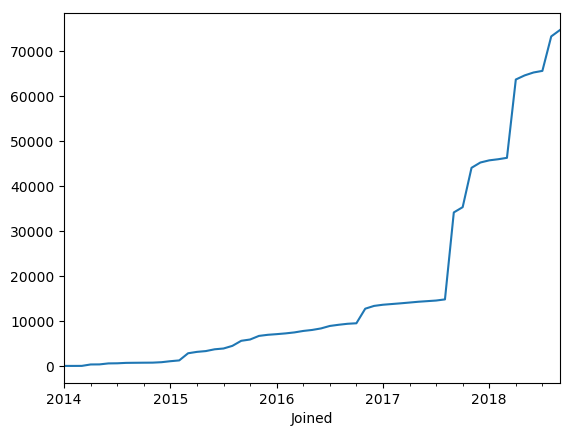

In [23]:
date_indexed = user_data.set_index(user_data["Joined"])
date_indexed['count'] = 1
counts = date_indexed['count'].resample('M').sum().dropna()

counts = counts[2:] #get rid of 2 obviously incorrect ones dating way back

import matplotlib.pyplot as plt
cumulative_counts = counts.cumsum()
cumulative_counts.plot()
plt.show()

# JOIN DATASETS

In [24]:
unique_cft.rename(index=str, columns={"EmailAddress": "Email"}, inplace=True)
alzu_survey_data.rename(index=str, columns={"uid_Open-Ended Response": "User ID"}, inplace=True)

/Users/travisallen/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [25]:
users_with_cognitive = user_data.merge(unique_cft, on="Email", how="left")

In [26]:
print(users_with_cognitive.shape)
users_with_cognitive.head()

(74779, 53)


,Joined,User ID,First Name,Email,Gender_x,Lesson Group,Lesson Count,Activ. Start,Activ. Compl.,UserID,FirstName,DoB,Gender_y,RegDate,Country,Postcode,Source,Ethnicy,MouseScore,Interrupted,Functioned,FastInternet,ScreenClear,FinalScore,DateTaken,Homoscyteine,MaritalStatus,Dependents,Occupation,PrimaryIncome,HouseholdIncome,PrimaryIncomeOccupation,FirstPriority,SecondPriority,OtherPriority,FullTime,PartTime,Working,CompUser,MemConcern,ForgetFriends,PutThings,ForgetWords,LoseWay,IsMemoryWorse,FamilyHistory,FamilyHistoryAge,Supplements,DeviceUsed,ass,combocs,recallscore,placescore
0,2018-09-11,75332,Lori,lori.wolfe@anthem.com,F,Prevention Default,2,3,1,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-09-11,75331,Robert,r.mango@live.com,M,Prevention Default,0,0,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-09-10,75330,George Rothwell,gogogeo@aol.com,M,Prevention Default,0,0,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-09-10,75329,Celeste,celestelovelace@yahoo.com,F,Prevention Default,0,0,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-09-10,75328,Laura D Zampaio,jadeverde1971@hotmail.com,F,Prevention Default,0,0,0,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
all_data = users_with_cognitive.merge(alzu_survey_data, on="User ID", how="left")

In [28]:
all_data.shape

(74779, 181)

# 4. Exploration of Combined Dataset

In [29]:
all_data.head()

,Joined,User ID,First Name,Email,Gender_x,Lesson Group,Lesson Count,Activ. Start,Activ. Compl.,UserID,FirstName,DoB,Gender_y,RegDate,Country,Postcode,Source,Ethnicy,MouseScore,Interrupted,Functioned,FastInternet,ScreenClear,FinalScore,DateTaken,Homoscyteine,MaritalStatus,Dependents,Occupation,PrimaryIncome,HouseholdIncome,PrimaryIncomeOccupation,FirstPriority,SecondPriority,OtherPriority,FullTime,PartTime,Working,CompUser,MemConcern,ForgetFriends,PutThings,ForgetWords,LoseWay,IsMemoryWorse,FamilyHistory,FamilyHistoryAge,Supplements,DeviceUsed,ass,combocs,recallscore,placescore,Respondent ID_,Collector ID_,Start Date_,End Date_,IP Address_,Email Address_,First Name_,Last Name_,Custom Data 1_,How many lessons did you complete on AlzU.org?_Response,Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response,Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Other (please specify),"Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Participated in an AD prevention research study other than this one?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to be evaluated for memory loss?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to prevent memory loss?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss an AD research study for a family member or friend?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, an AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, the Early Study AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Was screened for, or enrolled in, the Generation Study AD prevention clinical trial?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the AD prevention registry endALZnow.org?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the AD prevention registry BrainHealthRegistry.org?","Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Joined the Global Alzheimer's Platfo

In [30]:
cols = all_data.columns

In [31]:
for idx, col in enumerate(cols):
    print(str(idx) + " : " + str(col))

0 : Joined
1 : User ID
2 : First Name
3 : Email
4 : Gender_x
5 : Lesson Group
6 : Lesson Count
7 : Activ. Start
8 : Activ. Compl.
9 : UserID
10 : FirstName
11 : DoB
12 : Gender_y
13 : RegDate
14 : Country
15 : Postcode
16 : Source
17 : Ethnicy
18 : MouseScore
19 : Interrupted
20 : Functioned
21 : FastInternet
22 : ScreenClear
23 : FinalScore
24 : DateTaken
25 : Homoscyteine
26 : MaritalStatus
27 : Dependents
28 : Occupation
29 : PrimaryIncome
30 : HouseholdIncome
31 : PrimaryIncomeOccupation
32 : FirstPriority
33 : SecondPriority
34 : OtherPriority
35 : FullTime
36 : PartTime
37 : Working
38 : CompUser
39 : MemConcern
40 : ForgetFriends
41 : PutThings
42 : ForgetWords
43 : LoseWay
44 : IsMemoryWorse
45 : FamilyHistory
46 : FamilyHistoryAge
47 : Supplements
48 : DeviceUsed
49 : ass
50 : combocs
51 : recallscore
52 : placescore
53 : Respondent ID_
54 : Collector ID_
55 : Start Date_
56 : End Date_
57 : IP Address_
58 : Email Address_
59 : First Name_
60 : Last Name_
61 : Custom Data 1_
6

In [32]:
memory_prompt_idx = 176
tech_prompt_idx = 177

memory_prompt = cols[memory_prompt_idx]
tech_prompt = cols[tech_prompt_idx]

### Peform some Data Transformations

Convert the alzU columns to ints, and Replace "NaN" and empty strings with the mean of column

In [33]:
idx_of_first_alzu_q = 62
idx_of_last_non_prompt_alz_u_q = 175
open_ended_alzu_indices = [64, 99, 120, 122, 124, 134, 171,175] #columns where they could enter in anything 

for col_idx in range(idx_of_first_alzu_q, idx_of_last_non_prompt_alz_u_q + 1):
    col_name = cols[col_idx]
    if (col_idx in open_ended_alzu_indices):
        continue
    print(all_data[col_name].unique())
    
    # first convert all nan and empty to -1, so that the conversion of the column to astype int doesn't break
    all_data[col_name].fillna(-1, inplace=True) 
    all_data[col_name].replace([''], [-1], inplace=True)
    all_data[col_name].replace(['1.11111E+77'], [-1], inplace=True) # handle the bizarre entry that was breaking this
    all_data[col_name] = (all_data[col_name]).astype(int)
    
    all_data[col_name].replace([-1], [np.NaN], inplace=True)
    column_mean = all_data[col_name].mean()
    all_data[col_name].fillna(column_mean, inplace=True)
    
    
    
    print(str(col_idx) + ": " + col_name + ": " +str(all_data[col_name].dtype))
    print(all_data[col_name].unique())

[nan '1' '2' '3' '4' '']
62: How many lessons did you complete on AlzU.org?_Response: float64
[ 2.65112782  1.          2.          3.          4.        ]
[nan '0' '3' '' '7' '1' '2' '5' '4' '6']
63: Please select the reasons why you have not yet completed the full 10 lesson course on AlzU.org. Select ALL that apply_Response: float64
[ 1.35351882  0.          3.          7.          1.          2.          5.
  4.          6.        ]
[nan '' '5' '4' '3' '2' '1']
65: Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already done something related to the following behaviors:_Saw a doctor to discuss ways to lower AD risk?: float64
[ 2.81190926  5.          4.          3.          2.          1.        ]
[nan '' '5' '3' '2' '4' '1']
66: Below are listed several behaviors related to AD. Thinking back over the past three months, please indicate to what extent you have thought about or already

Rename gender column and replace with 0 (female) and 1 (male)

In [34]:
all_data.rename(index=str, columns={"Gender_x": "Gender"}, inplace=True)

all_data['Gender'].replace(['F','M'],[0,1],inplace=True)

Create an Age column based on the DoB column and get some stats on age

In [35]:
now = pd.Timestamp(DT.datetime.now())


dobs = pd.to_datetime(all_data[all_data['DoB'].notnull()]['DoB'])    # 1
dobs = dobs.where(dobs < now, dobs -  np.timedelta64(100, 'Y'))   # 2
# df['age'] = 
ages = (now - dobs).astype('<m8[Y]')    # 3

all_data['Age'] = ages

print("Average age is: " + str(ages.mean()))
print("Median age is: " + str(ages.median()))

Average age is: 60.4131016043
Median age is: 62.0


In [36]:
join_dates = pd.to_datetime(all_data[all_data['Joined'].notnull()]['Joined'])

join_dates = join_dates.where(join_dates < now, join_dates -  np.timedelta64(100, 'Y'))

days_as_member = (now - join_dates).astype('<m8[D]')

all_data['Days_As_Member'] = days_as_member

Transform some true false columns

In [37]:
def transform_true_false_col(col_name):
    replaced_NaNs = all_data[col_name].fillna(-1)
    replaced_t_f = replaced_NaNs.replace([False,True],[0,1])    
    replaced_t_f = replaced_t_f.astype(int)
    replaced_t_f.replace([-1], [np.NaN], inplace=True)
    column_mean = replaced_t_f.mean()
    replaced_t_f.fillna(column_mean, inplace=True)
    return replaced_t_f


all_data['MemConcern'] = transform_true_false_col('MemConcern')
all_data['ForgetFriends'] = transform_true_false_col('ForgetFriends')
all_data['PutThings'] = transform_true_false_col('PutThings')
all_data['ForgetWords'] = transform_true_false_col('ForgetWords')
all_data['LoseWay'] = transform_true_false_col('LoseWay')
all_data['IsMemoryWorse'] = transform_true_false_col('IsMemoryWorse')

Transform some yes no and other string columns...Taking some liberties here with how to encode them

In [38]:
all_data['FamilyHistory'].fillna(-1, inplace=True)
all_data['FamilyHistory'].replace(['', 'no', 'yes'], [-1,0,1], inplace=True)
all_data['FamilyHistory'].replace([-1], [np.NaN], inplace=True)

all_data['FamilyHistoryAge'].fillna(-1, inplace=True)
all_data['FamilyHistoryAge'].replace(['', 'Select', 'none', 'mild', 'other', 'alzh'], [-1,-1,0,1,2,3], inplace=True)
all_data['FamilyHistoryAge'].replace([-1], [np.NaN], inplace=True)

all_data['Supplements'].fillna(-1, inplace=True)
all_data['Supplements'].replace(['Select', 'No', 'Yes'], [-1,0,1], inplace=True)
all_data['Supplements'].replace([-1], [np.NaN], inplace=True)


Replace NANs in the prompt columns with empty strings 

In [39]:
all_data[memory_prompt].fillna('', inplace=True)
all_data[tech_prompt].fillna('', inplace=True)

In [40]:
all_data['FinalScore'] = pd.to_numeric(all_data['FinalScore'])

In [41]:
all_data['MouseScore'] = pd.to_numeric(all_data['FinalScore'])

In [42]:
print("Num respondents to memory prompt: "+ str(all_data[all_data[memory_prompt] != ''].shape[0]))
print("Num respondents to tech prompt: "+ str(all_data[all_data[tech_prompt] != ''].shape[0]))

Num respondents to memory prompt: 364
Num respondents to tech prompt: 424


In [43]:
cog_takers = all_data[all_data['FinalScore'].notnull()]
print("Num respondents with final cognitive score: " + str(cog_takers.shape[0]))

print("Average CFT Score: " + str(cog_takers['FinalScore'].mean()))
print("Median CFT Score: " + str(cog_takers['FinalScore'].median()))
print("Standard Deviation of CFT Score: " + str(cog_takers['FinalScore'].std()))

Num respondents with final cognitive score: 7501
Average CFT Score: 43.3708835997
Median CFT Score: 43.60862249
Standard Deviation of CFT Score: 9.38669314353


In [44]:
red_zone = cog_takers[cog_takers['FinalScore'] <= 38]
orange_zone = cog_takers[((cog_takers['FinalScore'] > 38) & (cog_takers['FinalScore'] <= 43))]
green_zone = cog_takers[cog_takers['FinalScore'] > 43]

print(red_zone.shape[0])
print(orange_zone.shape[0])
print(green_zone.shape[0])

2053
1502
3946


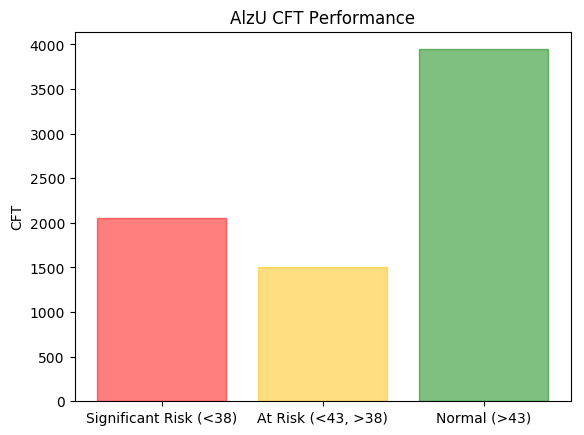

In [45]:
objects = ('Significant Risk (<38)', 'At Risk (<43, >38)', 'Normal (>43)')
y_pos = np.arange(len(objects))
performance = [red_zone.shape[0],orange_zone.shape[0], green_zone.shape[0]]
 
barlist=plt.bar(y_pos, performance, align='center', alpha=0.5)

barlist[0].set_color('#FF0000')
barlist[1].set_color('#FFBF00')
barlist[2].set_color('g')

plt.xticks(y_pos, objects)
plt.ylabel('CFT')
plt.title('AlzU CFT Performance')
 
plt.show()

In [46]:
users_with_cog_and_writing = all_data[((all_data[memory_prompt] != "") | (all_data[tech_prompt] != "")) & all_data['FinalScore'].notnull()]

print("Num respondents with cognitive scores and at least one response to writing prompts: " + str(users_with_cog_and_writing.shape[0]))

Num respondents with cognitive scores and at least one response to writing prompts: 171


# Model for users with cognitive scores

### For this section, we will ignore the written portion and see which variables are correlated with CFT score

In [47]:
y = cog_takers['FinalScore']
X = cog_takers.drop(['FinalScore'], axis=1)



Drop columns that we know are not good for ML models

In [48]:
X = X.drop(['Joined', 'User ID', 'First Name', 'Email', 'Lesson Group', 'UserID', 'FirstName', 'Respondent ID_', 'Collector ID_', 'IP Address_', 'Email Address_', 'First Name', 'Last Name_', 'Gender_y', 'DoB', 'joined_Open-Ended Response', 'email_Open-Ended Response', 'Start Date_', 'End Date_', 'First Name_', 'Custom Data 1_'], axis=1)

Drop columns THAT MAY BE OF USE LATER, but are just of inconvenient data types...

In [49]:
X = X.drop(['RegDate','DateTaken','Homoscyteine', 'Source', 'Working', 'CompUser', 'DeviceUsed'], axis=1)

There are many questions, particularly in the CFT portion, where there are no responses.  We drop those columns below

In [50]:
for col in X.columns:
    if (X[col].dtype != 'int64' and X[col].dtype != 'float64'):
        if(len(X[col].unique()) == 1 and X[col].unique() == ['']):
            X.drop(col, axis=1, inplace=True)
        


Drop the alzU columns where the format is open-ended.  Some of them have interesting data, but hard to think about how to convert them into numeric at this time.  Come back to this.

In [51]:
for open_ended_idx in open_ended_alzu_indices:
    col_name = cols[open_ended_idx]
    X.drop(col_name, axis=1, inplace=True)

Drop the written responses field for this round

In [52]:
X.drop(memory_prompt, axis=1, inplace=True)
X.drop(tech_prompt, axis=1,inplace=True)

In [53]:
# make sure that all columns are ints or floats and convert NaN into mean
for col in X.columns:
    if (X[col].dtype !='int64' and X[col].dtype !='float64'):
        print(col + ": " + str(X[col].dtype))
    else:
        column_mean = X[col].mean()
        X[col].fillna(column_mean, inplace=True)

In [54]:
# X = pd.DataFrame(X).fillna(-1) # this is to avoid an error related to values too high for 

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X,y)


print(X_train.shape)
print(X_test.shape)

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

(5625, 125)
(1876, 125)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
lin_reg.score(X_test, y_test)

1.0

In [57]:
y_test

34709    49.262929
26805    50.801265
68450    37.604850
62310    37.591088
58365    37.868197
11590    59.321330
57453    62.707878
53575    55.051750
35828    42.910502
30542    50.301812
39204    50.250310
24273    42.036782
65194    42.025938
45425    56.355851
55203    36.856580
17778    40.702665
12543    46.945432
51922    23.506571
27094    42.335762
68752    40.526069
12760    46.096499
25323    24.314641
21486    43.655363
61365    36.097055
50338    45.444114
46115    47.271854
6822     45.402856
61166    50.807638
68698    53.936989
43309    47.905422
           ...    
60578    37.960401
3395     53.021645
33131    43.107900
57940    41.113787
46186    50.709415
52404    42.642249
29266    57.039219
56227    32.738181
70751    38.727052
45155    24.915649
60437    32.015614
66738    50.002839
59281    14.101407
33117    59.191867
29333    28.865660
72070    41.554344
69169    45.951983
56323    52.893382
15800    24.596312
54967    59.305778
70884    52.907477
22090    45.